# Competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

## [Short Description](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/description) (and Disclaimer)

This is a “getting started” competition, where we use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. I used the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series) to help me get started, and a lot of the code in this notebook is from that course.rse are inspired by winning solutions from past Kaggle time series forecasting competitions.

## [Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

## [Data](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

### Training data: train.csv

* The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


### Test data: test.csv

* The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file. 
* The dates in the test data are for the 15 days after the last date in the training data.


### Submission file: sample_submission.csv
A sample submission file in the correct format.

### Additional information
#### 1. Store metadata: stores.csv
  * Store metadata, including **city**, **state**, **type**, and **cluster**.
  * **cluster** is a grouping of similar stores.

#### 2. Daily oil price: oil.csv 
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 3. Holidays and Events, with metadata: holidays_events.csv
  * NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
  * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


### Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Preliminaries

## Dependencies

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

## Competition Data

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Train data: train.csv
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# Holidays and Events, with metadata
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

# Test data: test.csv
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# EDA

[WIP]: Going to expand this section in upcoming weeks

In [4]:
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

# Modelling

As we learnt in the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series), there are 2 essential components of a time-series:
* **Time dependence** that leads to two key featues: [Trends](https://www.kaggle.com/code/ryanholbrook/trend) and [Seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality)
* **Serial depencdence** that leads to [cycles](https://www.kaggle.com/code/ryanholbrook/time-series-as-features), and can be explored through lag features.

Each of these features are worth exploring one-by-one in detail. We are goinig to follow the lead of the tutorial in realising that a single machine learning algorithm might not be best-suited to capture all these independent components. While regression algorithms are better for detrending/deseasonalising, [serial dependence is best explored through **decision trees**](https://www.kaggle.com/code/ryanholbrook/time-series-as-features). Hence, getting the best of both worlds, we are going to explore [Hybrid models](https://www.kaggle.com/code/ryanholbrook/hybrid-models) that employ a combination of the above algorithms.

## Trends

As defined in [Time Series course on Kaggle](https://www.kaggle.com/code/ryanholbrook/trend) course, the **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

The training set has information that drills down to different levels of detail, eg, store number, product family, etc. At the highest-level, we start looking at trends in the time-dependence of average sales.

In [5]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

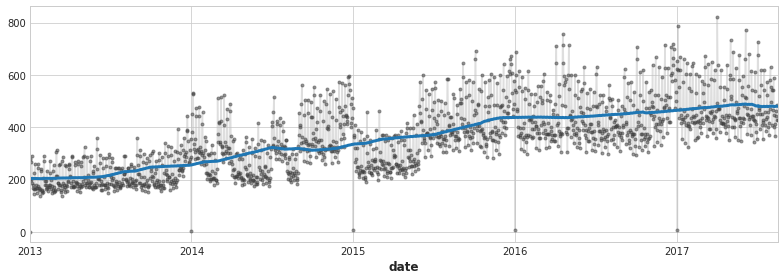

In [6]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [7]:
y = average_sales.copy()  # the target
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


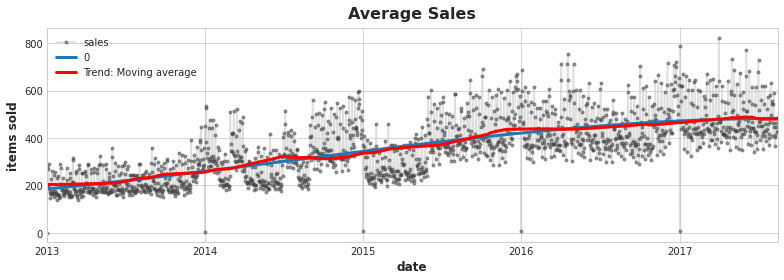

In [9]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index)


ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend: DeterministicProcess", color='C0')
ax = trend.plot(ax=ax, linewidth=3, label="Trend: Moving average", color='r')
ax.legend();

In [10]:
y = store_sales.unstack(['store_nbr', 'family'])  # the target
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   

                                                                         
store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  

[5 rows x 1782 columns]

In [11]:
from statsmodels.tsa.deterministic import DeterministicProcess

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [12]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [13]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09


In [14]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.061261
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.618728
                     BEVERAGES   3000891  2164.202471
                     BOOKS       3000892     0.639958